## 0 - Librairies

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness, Input, Add, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.config import run_functions_eagerly

In [26]:
#run_functions_eagerly((True))

## 1 - Data Preparation

In [27]:
X_train = np.load("Data/train_images.npy") 
y_train = np.load("Data/train_labels.npy") 
X_test = np.load("Data/test_images.npy")  
y_test = np.load("Data/test_labels.npy")  

In [28]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [29]:
# Normalize images
X_train = X_train.astype('float32')
X_test = X_test.astype('float32') / 255.0

In [30]:
# Reshape images for ResNet model
X_train_resnet = X_train.reshape(-1, 28, 28, 1)
X_test_resnet = X_test.reshape(-1, 28, 28, 1)

## 2 - Data Viz

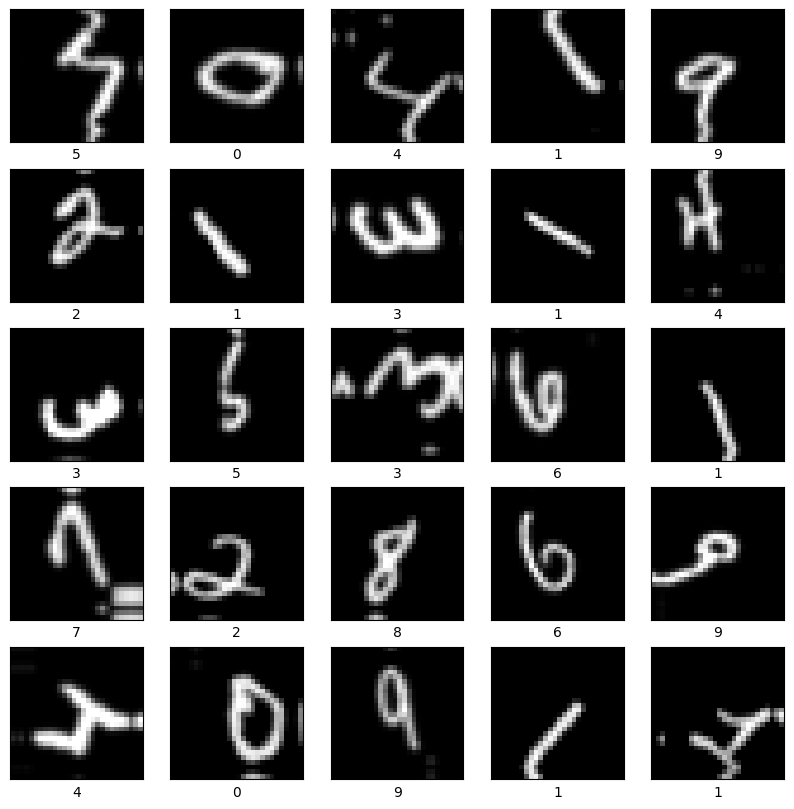

In [31]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

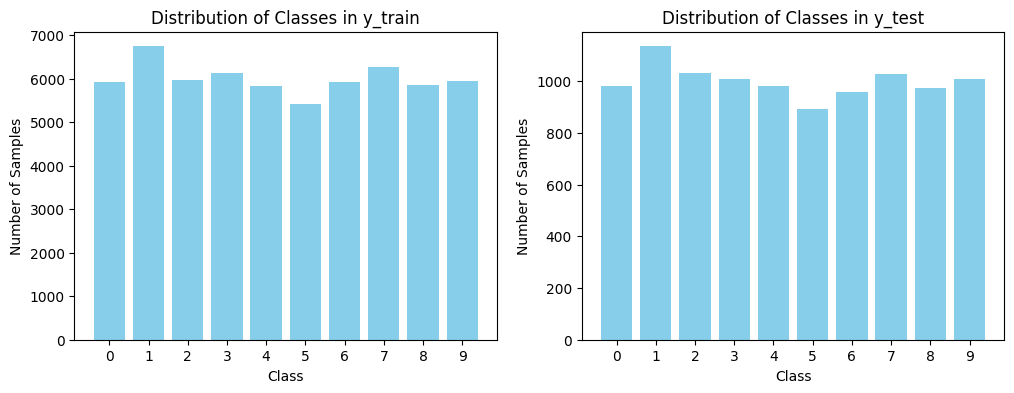

In [32]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - Dense Modele

### Parameters

In [33]:
# Parameters
epochs_resnet = 20
batch_size_resnet = 64
validation_split_resnet = .2
k_folds = 5
learning_rate_resnet = 0.001
metric_resnet = ["accuracy"]  #"SparseCategoricalAccuracy"
monitor_callback_resnet = "val_accuracy"
patience_callback_resnet = 4
mode_callback_resnet = None

### Modele

In [34]:
def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1):
    if output_channels is None:
        output_channels = input.shape[-1]

    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

    x_shortcut = input
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, (1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(output_channels, (1, 1), padding='same')(x)

    if input_channels != output_channels or stride != 1:
        x_shortcut = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(x_shortcut)

    output = Add()([x, x_shortcut])

    return output


def create_resnet_model(input_shape=(28, 28, 1), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual bloc
    x = residual_block(x, input_channels=16, output_channels=32)
    x = MaxPooling2D((2, 2))(x)

    # Pooling global
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_resnet),
                  loss='sparse_categorical_crossentropy',
                  metrics=metric_resnet)
    return model

In [35]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_resnet_model = None
best_accuracy = 0.0
best_resnet_history = None
histories_resnet = []

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resnet, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")
    X_train_fold, X_val_fold = X_train_resnet[train_idx], X_train_resnet[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    resnet_model = create_resnet_model()

    # Train the model
    history = resnet_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_resnet,
        batch_size=batch_size_resnet,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(monitor=monitor_callback_resnet, patience=patience_callback_resnet, mode=mode_callback_resnet, restore_best_weights=True)],
        verbose=1
    )

    histories_resnet.append(history)

    # Evaluate the model
    val_loss, val_accuracy = resnet_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    # Keep the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_resnet_model = resnet_model
        best_resnet_history = history

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")
print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_resnet_model.summary()


Fold 1/5


/home/hugob/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:77: UserWarning: EarlyStopping mode 'None' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, min_delta=min_delta)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.3098 - loss: 1.8830 - val_accuracy: 0.1482 - val_loss: 3.1307
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.5157 - loss: 1.3485 - val_accuracy: 0.1569 - val_loss: 6.0457
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.5881 - loss: 1.1705 - val_accuracy: 0.5727 - val_loss: 1.1716
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.6247 - loss: 1.0661 - val_accuracy: 0.5883 - val_loss: 1.1117
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.6516 - loss: 0.9947 - val_accuracy: 0.6612 - val_loss: 0.9566
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.6705 - loss: 0.9433 - val_accuracy: 0.6151 - val_loss: 1.0269
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.6898 - loss: 0.8973 - val_accuracy: 0.7096 - val_loss: 0.8176
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.7042 - loss: 0.8542 - 

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 14, 14,    │          0 │ activation_31[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ max_pooling2d_18… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 14, 14,    │        528 │ activation_32[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 14, 14,    │      2,320 │ activation_33[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 14, 14,    │        544 │ activation_34[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 14, 14,    │      1,056 │ max_pooling2d_18… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 14, 14,    │          0 │ conv2d_43[0][0],  │
│                     │ 32)               │            │ conv2d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 7, 7, 32)  │          0 │ add_9[0][0]     

 Total params: 19,232 (75.13 KB)

 Trainable params: 6,346 (24.79 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 12,694 (49.59 KB)

### Results

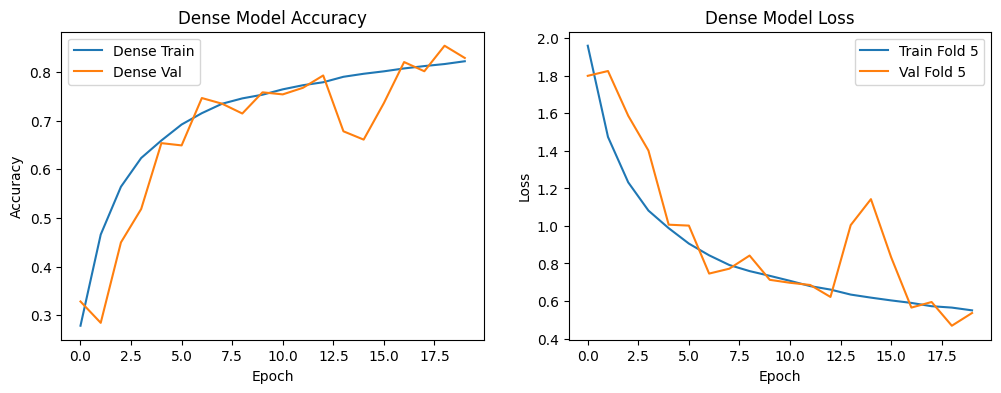

In [36]:
# summarize history for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_resnet_history.history['accuracy'], label='Dense Train')
plt.plot(best_resnet_history.history['val_accuracy'], label='Dense Val')
plt.title('Dense Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(best_resnet_history.history['loss'], label=f'Train Fold {i+1}')
plt.plot(best_resnet_history.history['val_loss'], label=f'Val Fold {i+1}')
plt.title('Dense Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [37]:
# Predict classes using the dense model
y_pred_resnet = best_resnet_model.predict(X_test)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


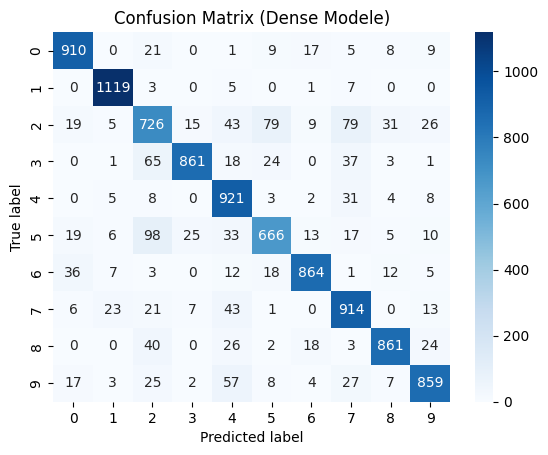

Class 0:
  Sensitivity (SEV): 0.9286
  Specificity (SPE): 0.9892

  Accuracy: 0.9833
  F1-score: 0.9160

Class 1:
  Sensitivity (SEV): 0.9859
  Specificity (SPE): 0.9944

  Accuracy: 0.9934
  F1-score: 0.9714

Class 2:
  Sensitivity (SEV): 0.7035
  Specificity (SPE): 0.9683

  Accuracy: 0.9410
  F1-score: 0.7111

Class 3:
  Sensitivity (SEV): 0.8525
  Specificity (SPE): 0.9945

  Accuracy: 0.9802
  F1-score: 0.8969

Class 4:
  Sensitivity (SEV): 0.9379
  Specificity (SPE): 0.9736

  Accuracy: 0.9701
  F1-score: 0.8603

Class 5:
  Sensitivity (SEV): 0.7466
  Specificity (SPE): 0.9842

  Accuracy: 0.9630
  F1-score: 0.7826

Class 6:
  Sensitivity (SEV): 0.9019
  Specificity (SPE): 0.9929

  Accuracy: 0.9842
  F1-score: 0.9162

Class 7:
  Sensitivity (SEV): 0.8891
  Specificity (SPE): 0.9769

  Accuracy: 0.9679
  F1-score: 0.8506

Class 8:
  Sensitivity (SEV): 0.8840
  Specificity (SPE): 0.9922

  Accuracy: 0.9817
  F1-score: 0.9039

Class 9:
  Sensitivity (SEV): 0.8513
  Specificity (SPE

In [38]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_resnet)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Dense Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}\n')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

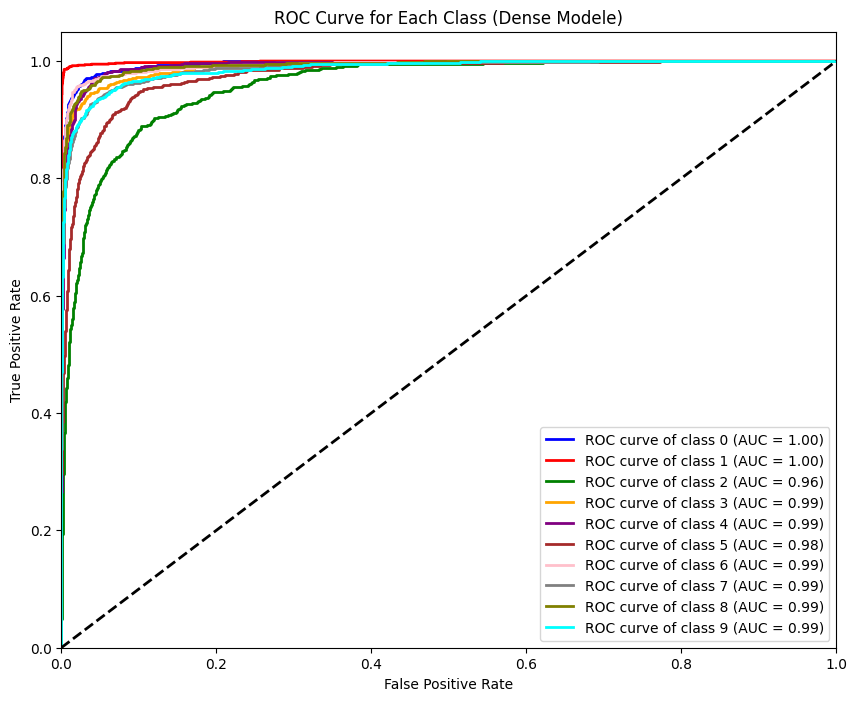

In [40]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_resnet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Dense Modele)')
plt.legend(loc="lower right")
plt.show()